In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### load data

In [7]:
df = pd.read_csv("spam.csv",encoding="latin1")

In [8]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df = df.rename(columns={"v1":"label","v2":"text"})[["label","text"]]

In [10]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [12]:
df.shape

(5572, 2)

In [13]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [14]:
df.isna().sum()

label    0
text     0
dtype: int64

In [15]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

## Message Length Feature

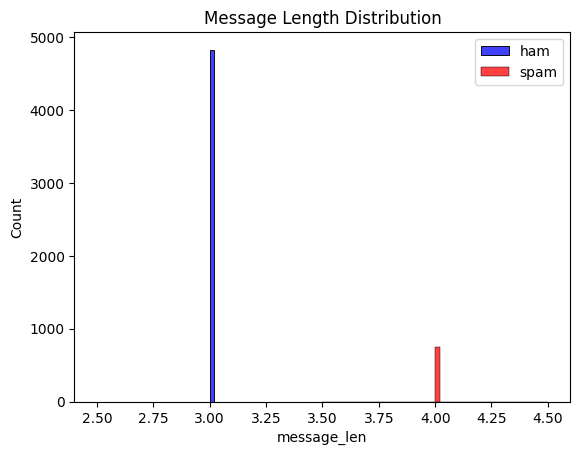

In [20]:
df['message_len']=df['label'].apply(len)
sns.histplot(df[df['label']=='ham']['message_len'],bins=50,color='blue',label='ham')
sns.histplot(df[df['label']=='spam']['message_len'],bins=50,color='red',label='spam')
plt.legend()
plt.title("Message Length Distribution")
plt.show()

## Distribution

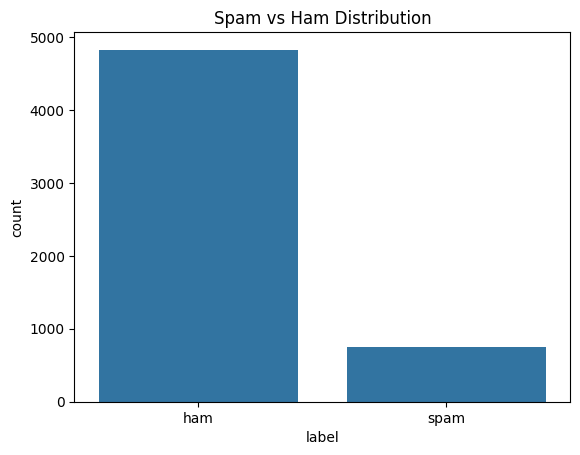

In [17]:
sns.countplot(x='label',data=df)
plt.title("Spam vs Ham Distribution")
plt.show()

## Modeling

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib
from sklearn.preprocessing import LabelEncoder

In [22]:
#Encode Labels
le = LabelEncoder()
df['label_num']= le.fit_transform(df['label'])

In [24]:
df.head()

,label,text,message_len,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",3,0
1,ham,Ok lar... Joking wif u oni...,3,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,4,1
3,ham,U dun say so early hor... U c already then say...,3,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",3,0


In [25]:
X = df['text']
y= df['label_num']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Model training and GridSearchCV

In [28]:
# Define model + parameter grid
log_reg = LogisticRegression(solver='liblinear')
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

In [29]:
# K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(log_reg, param_grid, cv=cv, scoring='accuracy', verbose=1)
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': [0.1, 1, ...], 'penalty': ['l1', 'l2']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [30]:
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'C': 10, 'penalty': 'l2'}
Best CV Score: 0.9791323801039796


## Evaluate Model

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
best_model = grid.best_estimator_

In [33]:
y_pred = best_model.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[960   5]
 [ 22 128]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.85      0.90       150

    accuracy                           0.98      1115
   macro avg       0.97      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



## Save the model

In [34]:
joblib.dump(best_model, "spam_model.pkl")
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']

In [35]:
#Load 
model = joblib.load("spam_model.pkl")
vectorizer = joblib.load("tfidf.pkl")